In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import Bunch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.generic.SettingWithCopyWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [19]:
df = pd.read_csv(r"C:\Users\DwaipayanChakroborti\OneDrive - Tonik Financial Pte Ltd\MyStuff\Biswa\Demographic_Retrain\Data\Demographic_score_retrain_20240925_V1.csv")

In [20]:
df['new_loan_type'].unique()

array(['SIL-Instore', 'Quick'], dtype=object)

In [21]:
df = df[df['new_loan_type'] == 'SIL-Instore']

In [22]:
df['disbursementDateTime'] =  pd.to_datetime(df['disbursementDateTime'])

df = df[(df['disbursementDateTime'] >= '2023-07-01') & (df['disbursementDateTime'] <= '2024-07-01')]

In [23]:
len(df)

70349

In [6]:
df['termsAndConditionsSubmitDateTime'] = pd.to_datetime(df['termsAndConditionsSubmitDateTime'])
df['tsa_onboarding_time'] = pd.to_datetime(df['tsa_onboarding_time'])

# Create a new column with the difference in seconds
df['tsa_time_Cashloan'] = (df['termsAndConditionsSubmitDateTime'] - df['tsa_onboarding_time']).dt.total_seconds()

In [7]:
df.head()

,digitalLoanAccountId,loanAccountNumber,customerId,new_loan_type,startApplyDateTime,disbursementDateTime,termsAndConditionsSubmitDateTime,tsa_onboarding_time,FSPD30,credolabScore,credolabScore_bin_SIL,credolabScore_bin_Cashloan,monthlyIncome,monthlyIncomeBin_sil,monthlyIncomeBin_cashloan,mobileinitials,telco_name_bin,deviceversion,devicevrs_bin,tsa_time_bin_cashloan,tsa_time_bin_sil,loanRequestTenure,loanRequestTenureBin_sil,subIndustryDescription,subIndustryDescriptionbin_sil,tsa_time_Cashloan
15185,7e6c8077-d1da-42c7-bdcf-7c85c1e68295,60825710150012,2571015,Quick,2024-06-12 08:03:59,2024-06-13 15:19:18,2024-06-13 14:14:05,2024-06-12 07:58:07,0,NaN,d. NULL,e. NULL,55500.0,d. 25650 - inf,d. 25650 - inf,761,d. Unknown Values,G4,"ios16, ios17",c. >= 0.285,d. >0.985,6,"b. [4.5, 7.5)",Call Centre / BPO,a. CallCenter/BPO,108958.0
15194,49e327ac-3b4e-4c13-b3c0-f1dcc398d0a5,60820542010014,2054201,Quick,2023-05-21 10:18:32,2023-05-22 17:20:54,2023-05-21 10:22:21,2023-05-21 01:38:09,1,NaN,d. NULL,e. NULL,25000.0,c. 24750 - 25650,c. 24750 - 25650,859,d. Unknown Values,G1,"android10, android11, android6, android7, andr...",c. >= 0.285,d. >0.985,6,"b. [4.5, 7.5)",Education / School / College / Online Coaching,b. e-CommerceConstructionHospitalTextile / Gar...,31452.0
15197,a53ea6d8-e33f-4d58-885b-a8a7d3bfbd0e,60822377230019,2237723,Quick,2023-09-17 22:04:19,2023-09-18 20:33:56,2023-09-17 22:07:34,2023-09-17 22:02:09,1,NaN,d. NULL,e. NULL,27500.0,d. 25650 - inf,d. 25650 - inf,909,c. Globe or TM,G4,"ios16, ios17",a. 0 - 0.195,b. 0.085 - 0.165,6,"b. [4.5, 7.5)",IT / Tech Consultancy / Projects / AI ML Solut...,b. e-CommerceConstructionHospitalTextile / Gar...,325.0
15200,79c27960-edad-47c8-b66d-f0bbb937e8d8,60826077770012,2607777,Quick,2024-06-25 10:26:38,2024-06-28 18:27:52,2024-06-25 10:36:19,2024-06-25 10:21:08,0,387.0,a. <416.5,a. <450.5,100000.0,d. 25650 - inf,d. 25650 - inf,609,d. Unknown Values,G3,"android13, android14",b. 0.195 - 0.285,c. 0.165 - 0.985,6,"b. [4.5, 7.5)",Banking,b. e-CommerceConstructionHospitalTextile / Gar...,911.0
15210,c74cc3dc-0ea0-430a-bfd5-116e7612f25d,60824727060011,2472706,Quick,2024-04-20 05:20:45,2024-04-20 16:33:55,2024-04-20 05:24:01,2024-04-20 05:18:05,0,NaN,d. NULL,e. NULL,45000.0,d. 25650 - inf,d. 25650 - inf,607,d. Unknown Values,G4,"ios16, ios17",a. 0 - 0.195,b. 0.085 - 0.165,6,"b. [4.5, 7.5)",Finance Company / Consumer Finance Company,b. e-CommerceConstructionHospitalTextile / Gar...,356.0


In [8]:
df['deviceversion'].unique()

array(['G4', 'G1', 'G3', 'G2', 'G5'], dtype=object)

In [9]:
df['FSPD30'].value_counts()

FSPD30
0    19612
1     4620
Name: count, dtype: int64

In [8]:
print(len(df['digitalLoanAccountId']))
print(df['digitalLoanAccountId'].nunique())

24232
24232


In [10]:
def add_woe_columns(df, target, binned_columns):
    # Total events and non-events in the dataset
    total_events = df[target].sum()
    total_non_events = len(df) - total_events

    # Loop through each binned column and calculate WOE
    for col in binned_columns:
        # Fill NaNs with 'Missing' for WOE calculation
        df[col] = df[col].fillna('Missing')
        
        # Group by the binned column and calculate event and non-event counts
        grouped = df.groupby(col)[target].agg(['sum', 'count'])
        grouped.columns = ['bad', 'total']

        # Calculate non-event counts for each bin
        grouped['good'] = grouped['total'] - grouped['bad']

        # Calculate event and non-event rates for each bin
        grouped['event_rate'] = grouped['bad'] / total_events
        grouped['non_event_rate'] = grouped['good'] / total_non_events

        # Calculate WOE and avoid division by zero
        grouped['WOE'] = np.log((grouped['good'] / total_non_events + 1e-10) / (grouped['bad'] / total_events + 1e-10))

        # Create a mapping from the binned column to WOE values
        woe_dict = grouped['WOE'].to_dict()

        # Map WOE values back to the original DataFrame as a new column
        df[f'{col}_WOE'] = df[col].map(woe_dict)
    
    return df

In [11]:
feature_list =[
             'credolabScore_bin_Cashloan',
            'monthlyIncomeBin_cashloan',
            'devicevrs_bin',
            'tsa_time_bin_cashloan',
                'telco_name_bin'
            ]

df_with_woe = add_woe_columns(df, target='FSPD30', binned_columns=feature_list)

In [14]:
df_with_woe[['monthlyIncomeBin_cashloan','monthlyIncomeBin_cashloan_WOE']].drop_duplicates()

,monthlyIncomeBin_cashloan,monthlyIncomeBin_cashloan_WOE
15185,d. 25650 - inf,0.086570
15194,c. 24750 - 25650,-0.181123
15289,b. 15830 - 24750,-0.126255
15679,a. 0 - 15830,-0.366417


In [16]:
df_with_woe['disbursementDateTime'].max()

Timestamp('2024-06-29 21:59:49')

In [33]:
df_with_woe['telco_name_bin'].unique()

array(['d. Unknown Values', 'c. Globe or TM', 'b. Smart or Talk N Text',
       'a. DITO, DITO or Globe or TM, DITO or Smart or Talk, Smart, Smart or TNT, Smart or Talk N Text, Sun Cellular, Unknown'],
      dtype=object)

In [13]:
df_with_woe.head()

,digitalLoanAccountId,loanAccountNumber,customerId,new_loan_type,startApplyDateTime,disbursementDateTime,termsAndConditionsSubmitDateTime,tsa_onboarding_time,FSPD30,credolabScore,credolabScore_bin_SIL,credolabScore_bin_Cashloan,monthlyIncome,monthlyIncomeBin_sil,monthlyIncomeBin_cashloan,mobileinitials,telco_name_bin,deviceversion,devicevrs_bin,tsa_time_bin_cashloan,tsa_time_bin_sil,loanRequestTenure,loanRequestTenureBin_sil,subIndustryDescription,subIndustryDescriptionbin_sil,tsa_time_Cashloan,credolabScore_bin_Cashloan_WOE,monthlyIncomeBin_cashloan_WOE,devicevrs_bin_WOE,tsa_time_bin_cashloan_WOE,telco_name_bin_WOE
15185,7e6c8077-d1da-42c7-bdcf-7c85c1e68295,60825710150012,2571015,Quick,2024-06-12 08:03:59,2024-06-13 15:19:18,2024-06-13 14:14:05,2024-06-12 07:58:07,0,NaN,d. NULL,e. NULL,55500.0,d. 25650 - inf,d. 25650 - inf,761,d. Unknown Values,G4,"ios16, ios17",c. >= 0.285,d. >0.985,6,"b. [4.5, 7.5)",Call Centre / BPO,a. CallCenter/BPO,108958.0,0.136827,0.086570,0.307898,0.125524,0.002736
15194,49e327ac-3b4e-4c13-b3c0-f1dcc398d0a5,60820542010014,2054201,Quick,2023-05-21 10:18:32,2023-05-22 17:20:54,2023-05-21 10:22:21,2023-05-21 01:38:09,1,NaN,d. NULL,e. NULL,25000.0,c. 24750 - 25650,c. 24750 - 25650,859,d. Unknown Values,G1,"android10, android11, android6, android7, andr...",c. >= 0.285,d. >0.985,6,"b. [4.5, 7.5)",Education / School / College / Online Coaching,b. e-CommerceConstructionHospitalTextile / Gar...,31452.0,0.136827,-0.181123,-0.408727,0.125524,0.002736
15197,a53ea6d8-e33f-4d58-885b-a8a7d3bfbd0e,60822377230019,2237723,Quick,2023-09-17 22:04:19,2023-09-18 20:33:56,2023-09-17 22:07:34,2023-09-17 22:02:09,1,NaN,d. NULL,e. NULL,27500.0,d. 25650 - inf,d. 25650 - inf,909,c. Globe or TM,G4,"ios16, ios17",a. 0 - 0.195,b. 0.085 - 0.165,6,"b. [4.5, 7.5)",IT / Tech Consultancy / Projects / AI ML Solut...,b. e-CommerceConstructionHospitalTextile / Gar...,325.0,0.136827,0.086570,0.307898,-0.314919,0.194132
15200,79c27960-edad-47c8-b66d-f0bbb937e8d8,60826077770012,2607777,Quick,2024-06-25 10:26:38,2024-06-28 18:27:52,2024-06-25 10:36:19,2024-06-25 10:21:08,0,387.0,a. <416.5,a. <450.5,100000.0,d. 25650 - inf,d. 25650 - inf,609,d. Unknown Values,G3,"android13, android14",b. 0.195 - 0.285,c. 0.165 - 0.985,6,"b. [4.5, 7.5)",Banking,b. e-CommerceConstructionHospitalTextile / Gar...,911.0,-0.515272,0.086570,0.266003,-0.127963,0.002736
15210,c74cc3dc-0ea0-430a-bfd5-116e7612f25d,60824727060011,2472706,Quick,2024-04-20 05:20:45,2024-04-20 16:33:55,2024-04-20 05:24:01,2024-04-20 05:18:05,0,NaN,d. NULL,e. NULL,45000.0,d. 25650 - inf,d. 25650 - inf,607,d. Unknown Values,G4,"ios16, ios17",a. 0 - 0.195,b. 0.085 - 0.165,6,"b. [4.5, 7.5)",Finance Company / Consumer Finance Company,b. e-CommerceConstructionHospitalTextile / Gar...,356.0,0.136827,0.086570,0.307898,-0.314919,0.002736


In [14]:
df_with_woe['disbursementDateTime'].min()

Timestamp('2023-01-07 04:56:30')

In [15]:
df_with_woe['disbursementDateTime'].max()

Timestamp('2024-06-29 21:59:49')

## Train Eval Test

In [16]:
feature_list_WOE=[
    'FSPD30',
      'credolabScore_bin_Cashloan_WOE',
        'monthlyIncomeBin_cashloan_WOE',
        'devicevrs_bin_WOE',
        'tsa_time_bin_cashloan_WOE',
            'telco_name_bin_WOE'
]
                


In [17]:
df_train_test = df_with_woe.loc[:, df_with_woe.columns.isin(feature_list_WOE)]

In [18]:
# Features and target variable
X =  df_train_test.drop(columns=['FSPD30'])
y = df_train_test['FSPD30']


from sklearn.model_selection import train_test_split

 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# LogReg

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

In [20]:
def gini(y_true, y_prob):
    return 2 * roc_auc_score(y_true, y_prob) - 1

# Instantiate logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for train and test sets
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

# Calculate Gini coefficients
gini_train = gini(y_train, train_preds)
gini_test = gini(y_test, test_preds)

# Output Gini coefficients
print('Train Gini:', gini_train)
print('Test Gini:', gini_test)

Train Gini: 0.23317630717504945
Test Gini: 0.2658850138868101


# Co efficients

In [21]:
# Get the coefficients directly from the logistic regression model
coefficients = model.coef_[0]

# Get the intercept
intercept = model.intercept_[0]

# Combine feature names with coefficients
feature_names = X_train.columns

# Create a DataFrame to display the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Add the intercept as a separate row
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept]})
coef_df = pd.concat([intercept_row, coef_df], ignore_index=True)

# Display the DataFrame
print(coef_df)


                          Feature  Coefficient
0                       Intercept    -1.444908
1  credolabScore_bin_Cashloan_WOE    -0.598524
2   monthlyIncomeBin_cashloan_WOE    -0.735178
3               devicevrs_bin_WOE    -0.946276
4       tsa_time_bin_cashloan_WOE    -1.056970
5              telco_name_bin_WOE    -0.715411


## Monthly Default Rate

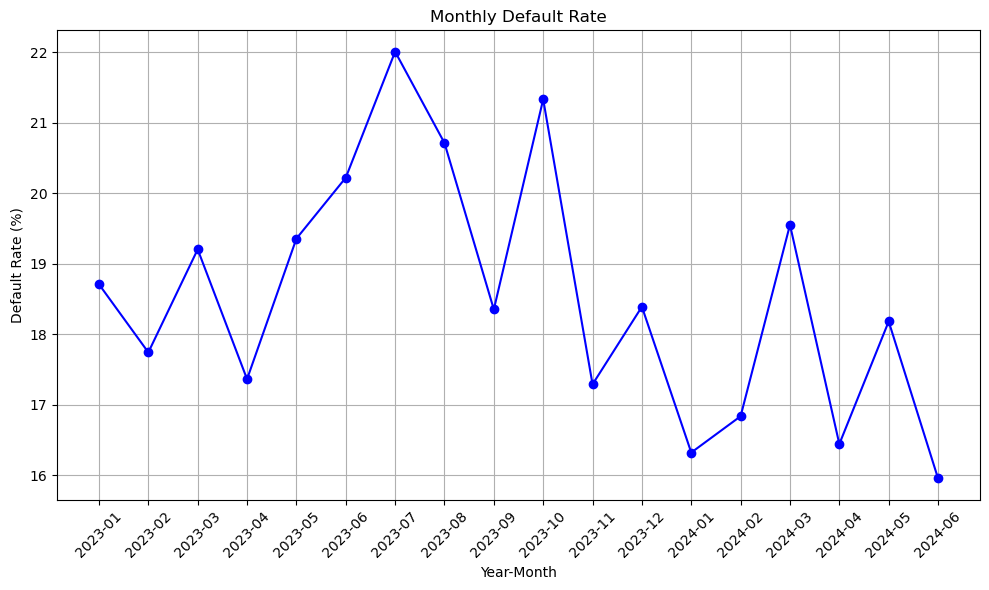

In [23]:
df1 =df
import matplotlib.pyplot as plt

df1['disbursementDateTime'] = pd.to_datetime(df1['disbursementDateTime'])

# Extract year-month in 'YYYY-MM' format for grouping
df1['year_month'] =df1['disbursementDateTime'].dt.to_period('M').astype(str)

# Calculate monthly default rate
monthly_default_rate = df1.groupby('year_month')['FSPD30'].mean().reset_index()
monthly_default_rate['default_rate'] = monthly_default_rate['FSPD30'] * 100  # Convert to percentage

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_default_rate['year_month'], monthly_default_rate['default_rate'], marker='o', color='b')
plt.title('Monthly Default Rate')
plt.xlabel('Year-Month')
plt.ylabel('Default Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## K fold

In [23]:
X =  df_train_test.drop(columns=['FSPD30'])
y = df_train_test['FSPD30']

In [24]:
from sklearn.model_selection import KFold

# Function to calculate Gini coefficient
def gini(y_true, y_prob):
    return 2 * roc_auc_score(y_true, y_prob) - 1

# Initialize logistic regression model
model = LogisticRegression()

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store Gini coefficients
train_gini_scores = []
test_gini_scores = []
feature_coefficients = []
intercepts=[]

# Dictionaries to store true labels and predicted probabilities across all folds
all_y_test_pred = {}

# Feature names
feature_names = X.columns

# Perform 10-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict probabilities for training and test sets
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]
    
    # Calculate Gini coefficients for training and test sets
    train_gini = gini(y_train, y_train_pred)
    test_gini = gini(y_test, y_test_pred)
    
    # Append Gini coefficients to their respective lists
    train_gini_scores.append(train_gini)
    test_gini_scores.append(test_gini)
    
    # Store predictions for the test set using test indices as keys
    for idx, pred in zip(test_index, y_test_pred):
        if idx not in all_y_test_pred:
            all_y_test_pred[idx] = []
        all_y_test_pred[idx].append(pred)

        
        
      # Store feature coefficients and intercept
    fold_feature_coefficients = model.coef_.flatten()
    fold_intercept = model.intercept_[0]
    feature_coefficients.append(fold_feature_coefficients)
    intercepts.append(fold_intercept)
    
    # Create DataFrame for the current fold's coefficients and intercept
    coeff_df = pd.DataFrame({
        'Feature': feature_names.tolist() + ['Intercept'],
        'Coefficient': list(fold_feature_coefficients) + [fold_intercept]
    })
    
#     # Print coefficients and intercept for the current fold
#     print(f"Fold {fold}:")
#     print(coeff_df)
#     print('-' * 40)
    
    
# Calculate the average predictions for each observation
average_predictions = np.array([np.mean(all_y_test_pred[idx]) for idx in sorted(all_y_test_pred.keys())])
average_y_test = np.array([y.iloc[idx] for idx in sorted(all_y_test_pred.keys())])


# Calculate and print average Gini coefficients
avg_train_gini = np.mean(train_gini_scores)
avg_test_gini = np.mean(test_gini_scores)

print(f"Average Train Gini: {avg_train_gini:.4f}")
print(f"Average Test Gini: {avg_test_gini:.4f}")

Average Train Gini: 0.2364
Average Test Gini: 0.2341
